# Initial data setup

## Imports

In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Data loading

### Address

In [5]:
all_addresses = pd.read_csv("../data/1_raw/bm_address.csv")
all_addresses.rename(columns={'id': 'address_id'}, inplace=True)


/var/folders/zv/r1h2xchs1gb4qpx11mwzrrv40000gn/T/ipykernel_14807/537795448.py:1: DtypeWarning: Columns (10,13,51) have mixed types. Specify dtype option on import or set low_memory=False.
  all_addresses = pd.read_csv("../data/1_raw/bm_address.csv")


In [6]:
# Sample 100 rows evenly spread throughout the addresses dataframe

sample_indices = np.linspace(0, len(all_addresses) - 1, 100, dtype=int)
address_samples = all_addresses.iloc[sample_indices]

# Write to CSV
address_samples.to_csv("../data/2_interim/100_address_samples_evenly_spread.csv", index=False)


### Ads

In [8]:
all_ads = pd.read_csv("../data/1_raw/finn_ads.csv")

In [35]:
# Sample 100 rows evenly spread throughout the ads dataframe
sample_indices = np.linspace(0, len(all_ads) - 1, 1000, dtype=int)
ads_sample = all_ads.iloc[sample_indices]

# Write to CSV
ads_sample.to_csv("../data/2_interim/100_ads_evenly_spread.csv", index=False)

### Transactions

In [66]:
all_transactions = pd.read_csv("../data/1_raw/bm_market_transactions.csv")
all_transactions.rename(columns={'id': 'transaction_id'}, inplace=True)

### Enova

In [79]:
enova = pd.read_csv("../data/1_raw/bm_enova_unit.csv")

# Pre-filtering

In [67]:
processed_transactions = all_transactions[all_transactions['official_price'] <= 30000000]

## Filter addresses based on kommune and buildings

Liste over kommunenr:
* Oslo: 301 (offisielt "0301" men "301" i datasettet)
* Lørenskog: 3222 (tidligare 3029)
* Lillestrøm: 3205 (tidligare 3030)
* Bærum: 3201 (tidligare 3024)
* Asker: 3203 (tidligare 3025)
* Drammen: 3301 (tidligare 3005)

"Tidligere" referer til hva kommunenummeret var før 2023. Ingen andre kommuner har nye kommunenummer som er likt dessa gamle kommunenummera. Per har testa kjapt at det ikkje er noen addresser registrert på gamle kommunenr

In [68]:
valid_buildings = all_addresses[all_addresses["bygningstype"].isin(["Enebolig", "Rekkehus", "Tomannsbolig, vertikaldelt", "Enebolig m/hybel/sokkelleil.", "Tomannsbolig, horisontaldelt"])]
print(f"Number of valid buildings nationwide: {len(valid_buildings)}")

Number of valid buildings nationwide: 1438693


In [69]:
kommunenr_east = [301, 3201, 3301, 3203, 3205, 3222]

In [70]:
eastern_addresses = all_addresses[all_addresses["kommunenr"].isin(kommunenr_east)]
eastern_relevant_addresses = eastern_addresses[eastern_addresses["bygningstype"].isin(valid_buildings["bygningstype"].unique())]
eastern_relevant_addresses.to_csv("../data/2_interim/eastern_relevant_addresses.csv", index=False)


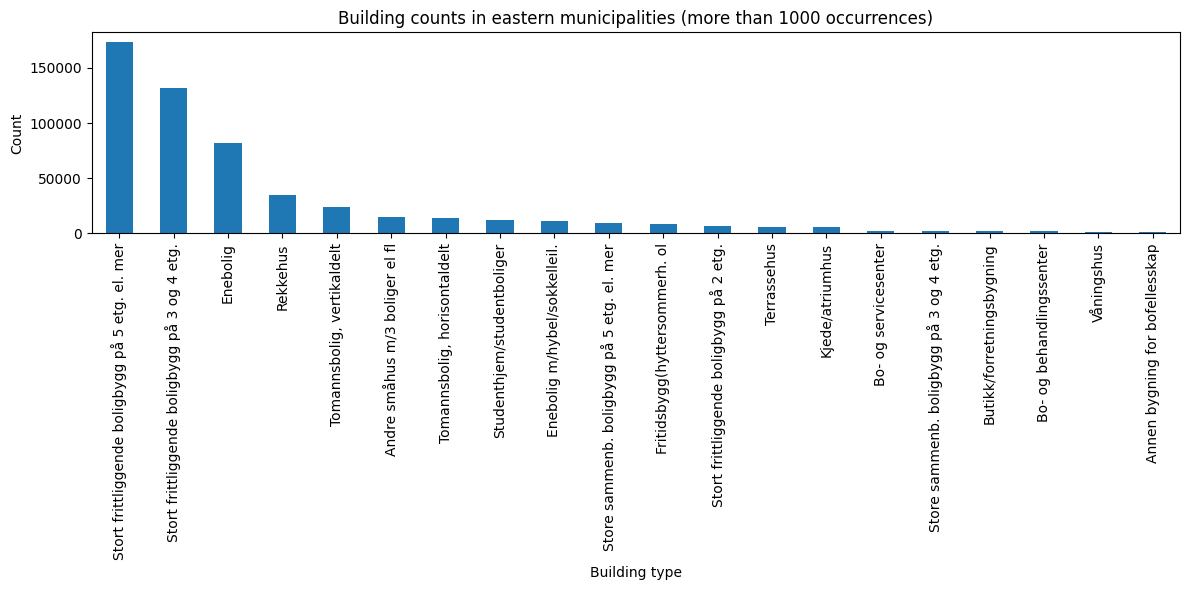

In [71]:
# Count occurrences of each bygningstype in eastern municipalities
buildings_count_east = eastern_addresses["bygningstype"].value_counts()

# Filter to only those with more than 1000 occurrences
buildings_count_east_filtered = buildings_count_east[buildings_count_east > 1000]

# Plot the result
plt.figure(figsize=(12, 6))
buildings_count_east_filtered.plot(kind='bar')
plt.title("Building counts in eastern municipalities (more than 1000 occurrences)")
plt.xlabel("Building type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Statistics for relevant addresses

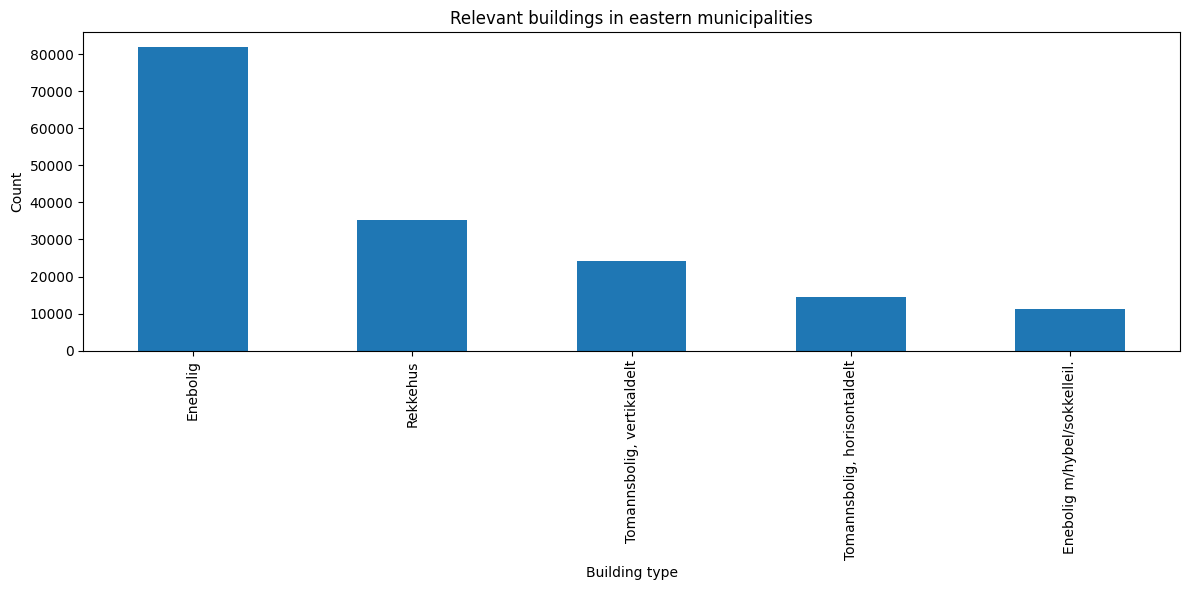

In [72]:
# Count occurrences of each bygningstype in eastern municipalities
relevant_buildings_count_east = eastern_relevant_addresses["bygningstype"].value_counts()

# Plot the result
plt.figure(figsize=(12, 6))
relevant_buildings_count_east.plot(kind='bar')
plt.title("Relevant buildings in eastern municipalities")
plt.xlabel("Building type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Addresses with multiple transactions

In [73]:
# Find address_id with more than one transaction_id
address_transaction_counts = processed_transactions.groupby('address_id')['transaction_id'].nunique()
addresses_with_multiple_transactions = address_transaction_counts[address_transaction_counts > 1].index

print(f"Number of addresses with multiple transactions: {len(addresses_with_multiple_transactions)}")

Number of addresses with multiple transactions: 818591


In [74]:
# Get the address_id column from addresses_east as a set
eastern_relevant_addresses_ids = set(eastern_relevant_addresses["address_id"])

# Intersection with addresses_with_multiple_transactions (which is an Index, so convert to set)
eastern_addresses_with_multiple_transactions = set(addresses_with_multiple_transactions) & eastern_relevant_addresses_ids

# Filter processed_transactions for these addresses
multiple_transactions_df = processed_transactions[processed_transactions['address_id'].isin(eastern_addresses_with_multiple_transactions)]

print(f"Number of eastern addresses with multiple transactions recorded: {len(eastern_addresses_with_multiple_transactions)}")
print(f"Number of transactions for these addresses: {len(multiple_transactions_df)}")


Number of eastern addresses with multiple transactions recorded: 53039
Number of transactions for these addresses: 141411


### Addresses with multiple ads

In [78]:
# Find address_id with more than one ad_code
address_ad_counts = processed_transactions.groupby('address_id')['ad_code'].nunique()
addresses_with_multiple_ads = address_ad_counts[address_ad_counts > 1].index

print(f"Number of addresses nationwide with multiple ads: {len(addresses_with_multiple_ads)}")

Number of addresses nationwide with multiple ads: 171625


In [76]:
# Intersection with addresses_with_multiple_ads (which is an Index, so convert to set)
eastern_addresses_with_multiple_ads = set(addresses_with_multiple_ads) & eastern_relevant_addresses_ids

print(f"Number of eastern addresses with multiple ads recorded: {len(eastern_addresses_with_multiple_ads)}")

# Filter processed_transactions for these addresses
multiple_ads_df = processed_transactions[processed_transactions['address_id'].isin(eastern_addresses_with_multiple_ads)]

Number of eastern addresses with multiple ads recorded: 8303


In [77]:
# Filter filtered_processed_transactions to only include rows with ad_code present in ads DataFrame
multiple_ads_df_filtered = multiple_ads_df[
	multiple_ads_df['ad_code'].isin(all_ads['ad_code'])
]
print(f"Number of ads for these addresses: {len(multiple_ads_df_filtered)}")


Number of ads for these addresses: 18085


## Enova

In [84]:
filtered_enova = enova[enova['address_id'].isin(eastern_addresses_with_multiple_ads)]
print(f"Number of Enova records for eastern relevant addresses: {len(filtered_enova)}")

Number of Enova records for eastern relevant addresses: 19287


In [85]:
# Count the number of distinct address_id in filtered_enova that have more than one occurrence
address_counts = filtered_enova['address_id'].value_counts()
num_address_ids_more_than_one = (address_counts > 1).sum()
print(f"Number of eastern relevant addresses with more than one Enova record: {num_address_ids_more_than_one}")


Number of eastern relevant addresses with more than one Enova record: 5577


In [86]:
# Find address_ids in filtered_enova with more than one occurrence
address_counts_filtered = filtered_enova['address_id'].value_counts()
address_ids_multiple = address_counts_filtered[address_counts_filtered > 1].index

# For these address_ids, count how many have different energy_score values
grouped = filtered_enova[filtered_enova['address_id'].isin(address_ids_multiple)].groupby('address_id')['energy_score']
num_with_different_scores = grouped.nunique()
count_different_scores = (num_with_different_scores > 1).sum()

print("Number of address_ids with more than one occurrence and different energy_score values:", count_different_scores)


Number of address_ids with more than one occurrence and different energy_score values: 2511


In [87]:
# For these address_ids, count how many have different heating_score values
grouped = filtered_enova[filtered_enova['address_id'].isin(address_ids_multiple)].groupby('address_id')['heating_score']
num_with_different_scores = grouped.nunique()
count_different_scores = (num_with_different_scores > 1).sum()

print("Number of address_ids with more than one occurrence and different heating_score values:", count_different_scores)

Number of address_ids with more than one occurrence and different heating_score values: 2321
